In [1]:
!pip install torch torchvision opencv-python matplotlib imutils
!pip install timm torch torchvision opencv-python matplotlib


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from PIL import Image
import imutils
import timm  # EfficientNet is available through the timm library
from torchvision.datasets import ImageFolder
from google.colab import drive
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import torchvision.models as models
import random
from torchvision import transforms
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = "/content/drive/MyDrive/dataset"

Cropping images

In [5]:
def crop_brain_tumor(image):
    """
    Automatically detects the largest contour in the image and crops the tumor region.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply binary threshold
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        return image  # Return original if no tumor found

    # Get largest contour
    c = max(cnts, key=cv2.contourArea)

    # Find extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Apply cropping
    ADD_PIXELS = 10  # Add padding
    cropped_image = image[max(0, extTop[1]-ADD_PIXELS):extBot[1]+ADD_PIXELS,
                          max(0, extLeft[0]-ADD_PIXELS):extRight[0]+ADD_PIXELS]

    return cropped_image

Data augmentation

In [6]:
class CustomTransform:
    def __call__(self, img):
        # Convert PIL image to NumPy array for OpenCV processing
        img_np = np.array(img)

        # Apply brain tumor cropping
        cropped_img = crop_brain_tumor(img_np)

        # Convert back to PIL Image for torchvision transformations
        img_pil = Image.fromarray(cropped_img)

        # Apply augmentations
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to standard size
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop randomly
            transforms.RandomRotation(30),  # Random rotation
            transforms.RandomHorizontalFlip(),  # Randomly flip image
            transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color augmentation
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
        ])

        return transform(img_pil)

Importing dataset

In [7]:
dataset = datasets.ImageFolder(root=dataset_path, transform=CustomTransform())
# Print class names
class_names = dataset.classes
print("Classes:", class_names)

Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


Train-validation split

In [8]:
# Define train-validation split
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Training images: {len(train_ds)}, Validation images: {len(val_ds)}, test images: {len(test_ds)}")

Training images: 2212, Validation images: 632, test images: 316


In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Flip images randomly
    transforms.RandomRotation(20),  # Rotate images randomly
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply transformations only to the training set
train_ds.dataset.transform = train_transform

Visulization

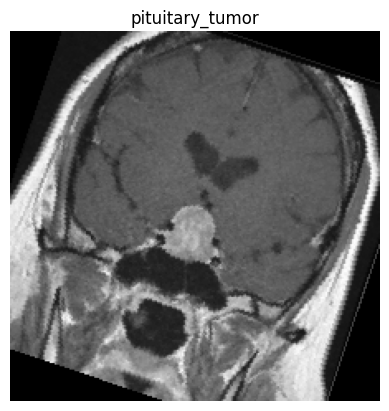

In [10]:
def imshow(img, label):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title(class_names[label])
    plt.axis("off")
    plt.show()

# Get one batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the first image
imshow(images[0], labels[0].item())

In [11]:
import torch
import torch.nn as nn
# Define the CNN model in PyTorch
class CNNModel(nn.Module):
    def __init__(self, conv_layers, layer_size, dense_layers):
        super(CNNModel, self).__init__()
        self.conv_layers = conv_layers
        self.layer_size = layer_size
        self.dense_layers = dense_layers

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, layer_size, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

        # Additional convolutional layers
        self.conv2 = nn.Conv2d(layer_size, layer_size, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(layer_size, layer_size, kernel_size=3, padding=1)

        # Calculate the size of the feature map after the convolutional layers
        # Assuming input size of 224x224, and 2x2 pooling after each conv layer
        self.feature_map_size = 224 // (2 ** conv_layers)  # Dividing by 2 for each pooling layer

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(layer_size * self.feature_map_size * self.feature_map_size, dense_layers * 128)  # Adjust size
        self.fc2 = nn.Linear(dense_layers * 128, 4)  # 4 output classes

        # Dropout layer
        self.dropout = nn.Dropout(0.33)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        if self.conv_layers > 1:
            x = self.relu(self.conv2(x))
            x = self.maxpool(x)

        if self.conv_layers > 2:
            x = self.relu(self.conv3(x))
            x = self.maxpool(x)

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [12]:
import torch.optim as optim
from sklearn.metrics import classification_report

# Function to train the model
def train_model(model, train_loader, val_loader, device, epochs=20):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_preds.double() / total_preds
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss / len(train_loader)
        }
        checkpoint_path = "/content/drive/My Drive/cnn_brain_tumor_checkpoint.pth"
        save_checkpoint(checkpoint, checkpoint_path)

        # Evaluate the model on validation data
        val_acc = evaluate_model(model, val_loader, device)
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model


In [13]:
# Save checkpoint function
def save_checkpoint(checkpoint, checkpoint_path):
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

In [14]:
# Load checkpoint function
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {checkpoint_path}")
    print(f"Resumed from epoch {epoch}, loss: {loss}")
    return model, optimizer, epoch

In [15]:
import torch
import numpy as np
from sklearn.metrics import classification_report

# Function to evaluate the model
def evaluate_model(model, val_loader, device):
    model.eval()
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred))
    return accuracy

In [16]:
from torch.utils.data import DataLoader, random_split

# Assuming the datasets have already been loaded in previous code as 'train_ds' and 'val_ds'
# Otherwise, import or call the datasets here if not already available

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


In [17]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
conv_layers = 3
layer_size = 64
dense_layers = 2
epochs = 20

# Initialize model
model = CNNModel(conv_layers=conv_layers, layer_size=layer_size, dense_layers=dense_layers)

Using device: cuda


In [18]:
# Train the model
trained_model = train_model(model, train_loader, val_loader, device, epochs)

# Evaluate the model
evaluate_model(trained_model, val_loader, device)


Epoch 1/20 - Loss: 1.1005 - Accuracy: 0.5470
Checkpoint saved to /content/drive/My Drive/cnn_brain_tumor_checkpoint.pth
Validation Accuracy: 0.6772
              precision    recall  f1-score   support

           0       0.71      0.54      0.61       185
           1       0.60      0.74      0.66       199
           2       0.71      0.36      0.48        84
           3       0.74      0.91      0.82       164

    accuracy                           0.68       632
   macro avg       0.69      0.64      0.64       632
weighted avg       0.68      0.68      0.66       632

Epoch 2/20 - Loss: 0.8152 - Accuracy: 0.6546
Checkpoint saved to /content/drive/My Drive/cnn_brain_tumor_checkpoint.pth
Validation Accuracy: 0.6820
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       185
           1       0.59      0.72      0.65       199
           2       0.93      0.31      0.46        84
           3       0.71      0.94      0.81       16

tensor(0.8465, device='cuda:0', dtype=torch.float64)

In [19]:
# Function to test the model
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred))
    return accuracy

# Assuming you already have the test_loader prepared

# Test the model
test_accuracy = test_model(trained_model, test_loader, device)

Test Accuracy: 0.8734
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        97
           1       0.82      0.82      0.82        83
           2       0.93      0.76      0.83        49
           3       0.93      0.98      0.96        87

    accuracy                           0.87       316
   macro avg       0.88      0.86      0.87       316
weighted avg       0.87      0.87      0.87       316



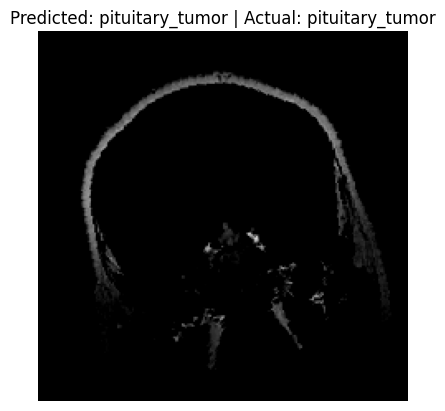

Predicted Label: pituitary_tumor
Actual Label: pituitary_tumor


In [20]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

def test_random_image(model, test_loader, device, class_names):
    # Set the model to evaluation mode
    model.eval()

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(trained_model, test_loader, device, class_names)

## **1.SWIN :**

In [21]:
# Charger Swin-Tiny pré-entraîné
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(dataset.classes))

# Définir l'appareil (GPU si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze the early layers and fine-tune the last few layers (classifier head)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the classifier layer (head)
for param in model.head.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Époque {epoch+1}/{num_epochs} - Perte: {running_loss/len(train_loader):.4f}")

print("Entraînement terminé !")

# Evaluation on the validation set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accurancy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Époque 1/20 - Perte: 1.2751
Époque 2/20 - Perte: 1.1482
Époque 3/20 - Perte: 1.0553
Époque 4/20 - Perte: 0.9822
Époque 5/20 - Perte: 0.9247
Époque 6/20 - Perte: 0.8759
Époque 7/20 - Perte: 0.8375
Époque 8/20 - Perte: 0.8078
Époque 9/20 - Perte: 0.7809
Époque 10/20 - Perte: 0.7544
Époque 11/20 - Perte: 0.7298
Époque 12/20 - Perte: 0.7177
Époque 13/20 - Perte: 0.7053
Époque 14/20 - Perte: 0.6900
Époque 15/20 - Perte: 0.6829
Époque 16/20 - Perte: 0.6628
Époque 17/20 - Perte: 0.6450
Époque 18/20 - Perte: 0.6487
Époque 19/20 - Perte: 0.6292
Époque 20/20 - Perte: 0.6153
Entraînement terminé !
Accurancy: 75.79%


# a.Test Model :

In [22]:
# Function to test the model
def test_model(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    return accuracy



# Test the model (using your trained model)
test_accuracy = test_model(model, test_loader, device, class_names)


Test Accuracy: 0.7658
                  precision    recall  f1-score   support

    glioma_tumor       0.80      0.81      0.81        97
meningioma_tumor       0.66      0.69      0.67        83
        no_tumor       0.84      0.53      0.65        49
 pituitary_tumor       0.80      0.92      0.86        87

        accuracy                           0.77       316
       macro avg       0.77      0.74      0.75       316
    weighted avg       0.77      0.77      0.76       316



# b.Test Random Image

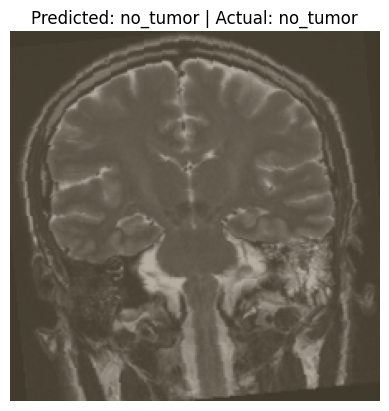

Predicted Label: no_tumor
Actual Label: no_tumor


In [23]:
def test_random_image(model, test_loader, device, class_names):
    # Set the model to evaluation mode
    model.eval()

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Normalize the image to match the Swin-Tiny's input normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Ensure the image is in the correct range

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(model, test_loader, device, class_names)


# **2.ResNeT**

In [24]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer for your number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze all layers except the final one (fc layer)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the final classifier layer
for param in model.fc.parameters():
    param.requires_grad = True  # Unfreeze the classifier layer

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimizer should only optimize the parameters of the final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass to get predictions
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass to calculate gradients
        loss.backward()

        # Step the optimizer to update the weights
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


Epoch 1/20 - Loss: 1.3612
Epoch 2/20 - Loss: 1.2212
Epoch 3/20 - Loss: 1.1280
Epoch 4/20 - Loss: 1.0376
Epoch 5/20 - Loss: 0.9788
Epoch 6/20 - Loss: 0.9328
Epoch 7/20 - Loss: 0.8917
Epoch 8/20 - Loss: 0.8513
Epoch 9/20 - Loss: 0.8239
Epoch 10/20 - Loss: 0.7975
Epoch 11/20 - Loss: 0.7816
Epoch 12/20 - Loss: 0.7550
Epoch 13/20 - Loss: 0.7403
Epoch 14/20 - Loss: 0.7314
Epoch 15/20 - Loss: 0.7143
Epoch 16/20 - Loss: 0.7008
Epoch 17/20 - Loss: 0.7059
Epoch 18/20 - Loss: 0.6923
Epoch 19/20 - Loss: 0.6836
Epoch 20/20 - Loss: 0.6677
Training complete!
Accuracy: 76.11%


# a.Test Model :

In [25]:
# Function to test the model
def test_model(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    return accuracy



# Test the ResNet18 model
test_accuracy = test_model(model, test_loader, device, class_names)


Test Accuracy: 0.7468
                  precision    recall  f1-score   support

    glioma_tumor       0.86      0.75      0.80        97
meningioma_tumor       0.58      0.70      0.63        83
        no_tumor       0.88      0.45      0.59        49
 pituitary_tumor       0.78      0.95      0.86        87

        accuracy                           0.75       316
       macro avg       0.78      0.71      0.72       316
    weighted avg       0.77      0.75      0.74       316



# b.Test Random Image

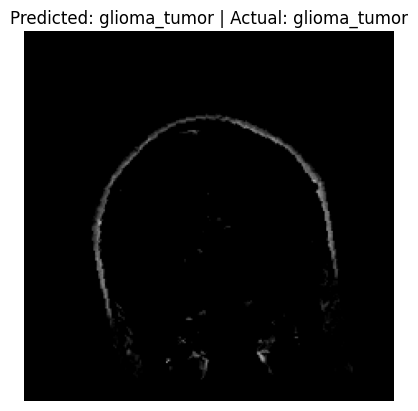

Predicted Label: glioma_tumor
Actual Label: glioma_tumor


In [26]:
# Function to test a random image
def test_random_image(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(model, test_loader, device, class_names)


# **3.VGG16**

In [27]:

# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Modify the final fully connected layer for your number of classes
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(dataset.classes))

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False
# Unfreeze the final classifier layer
for param in model.classifier[6].parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

# Pass only the parameters of the final layer to the optimizer
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 108MB/s]


Epoch 1/20 - Loss: 1.2567
Epoch 2/20 - Loss: 1.0435
Epoch 3/20 - Loss: 0.9386
Epoch 4/20 - Loss: 0.8760
Epoch 5/20 - Loss: 0.8250
Epoch 6/20 - Loss: 0.7968
Epoch 7/20 - Loss: 0.7818
Epoch 8/20 - Loss: 0.7716
Epoch 9/20 - Loss: 0.7553
Epoch 10/20 - Loss: 0.7414
Epoch 11/20 - Loss: 0.7286
Epoch 12/20 - Loss: 0.7164
Epoch 13/20 - Loss: 0.6971
Epoch 14/20 - Loss: 0.6714
Epoch 15/20 - Loss: 0.6935
Epoch 16/20 - Loss: 0.6758
Epoch 17/20 - Loss: 0.6779
Epoch 18/20 - Loss: 0.6610
Epoch 19/20 - Loss: 0.6585
Epoch 20/20 - Loss: 0.6581
Training complete!
Accuracy: 74.68%


# a.Test Model :

In [28]:
# Function to test the model
def test_model(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    return accuracy



# Test the VGG16 model
test_accuracy = test_model(model, test_loader, device, class_names)


Test Accuracy: 0.7500
                  precision    recall  f1-score   support

    glioma_tumor       0.78      0.81      0.80        97
meningioma_tumor       0.66      0.59      0.62        83
        no_tumor       0.82      0.57      0.67        49
 pituitary_tumor       0.76      0.93      0.84        87

        accuracy                           0.75       316
       macro avg       0.76      0.73      0.73       316
    weighted avg       0.75      0.75      0.74       316



# b.Test Random Image

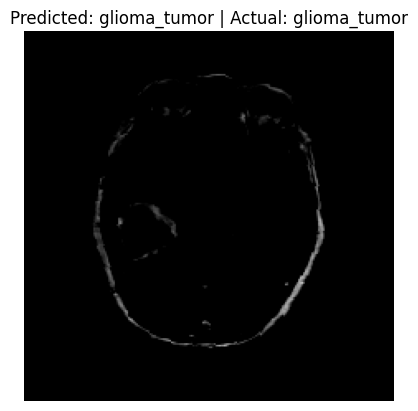

Predicted Label: glioma_tumor
Actual Label: glioma_tumor


In [29]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

# Function to test a random image
def test_random_image(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(model, test_loader, device, class_names)


# **4.EfficientNet**

In [30]:
# Load pre-trained EfficientNet-B0 model
model = timm.create_model('efficientnet_b0', pretrained=True)

# Modify the final layer to match the number of classes
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(dataset.classes))

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final classifier layer
for param in model.classifier.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimizer should only optimize the parameters of the final classifier
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/20 - Loss: 1.2730
Epoch 2/20 - Loss: 1.1013
Epoch 3/20 - Loss: 0.9877
Epoch 4/20 - Loss: 0.9069
Epoch 5/20 - Loss: 0.8412
Epoch 6/20 - Loss: 0.7909
Epoch 7/20 - Loss: 0.7545
Epoch 8/20 - Loss: 0.7225
Epoch 9/20 - Loss: 0.6927
Epoch 10/20 - Loss: 0.6682
Epoch 11/20 - Loss: 0.6629
Epoch 12/20 - Loss: 0.6447
Epoch 13/20 - Loss: 0.6268
Epoch 14/20 - Loss: 0.6059
Epoch 15/20 - Loss: 0.5908
Epoch 16/20 - Loss: 0.5876
Epoch 17/20 - Loss: 0.5719
Epoch 18/20 - Loss: 0.5681
Epoch 19/20 - Loss: 0.5643
Epoch 20/20 - Loss: 0.5525
Training complete!
Accuracy: 80.22%


# a.Test Model :

In [31]:
# Function to test the model
def test_model(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    return accuracy



# Test the EfficientNet-B0 model
test_accuracy = test_model(model, test_loader, device, class_names)


Test Accuracy: 0.7848
                  precision    recall  f1-score   support

    glioma_tumor       0.83      0.78      0.80        97
meningioma_tumor       0.67      0.72      0.70        83
        no_tumor       0.80      0.65      0.72        49
 pituitary_tumor       0.84      0.92      0.88        87

        accuracy                           0.78       316
       macro avg       0.79      0.77      0.78       316
    weighted avg       0.79      0.78      0.78       316



# b.Test Random Image

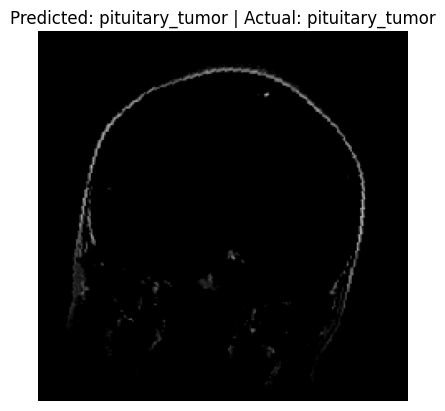

Predicted Label: pituitary_tumor
Actual Label: pituitary_tumor


In [32]:
# Function to test a random image
def test_random_image(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(model, test_loader, device, class_names)
